In [1]:
import  cv2
import numpy as np
import os
import time
import mediapipe as mp
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
 

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)

In [4]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    left_hand = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    right_hand = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose,left_hand,right_hand])

In [19]:
DATA_PATH = os.path.join('MP_Data')

In [6]:
actions = np.array(['yes','no','hello','Thank you','learn','understand','you','I','sign','what','name','like'])
no_sequences = 30
sequence_length = 30
start_folder = 30

In [60]:
for action in actions:
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [61]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [21]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [12]:
# callback = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1,patience = 10)

In [7]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape =(30,258)))
# model.add(GRU(128, return_sequences=True, activation='relu'))
model.add(GRU(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32,  activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 114,284
Trainable params: 114,284
Non-trainable params: 0
_________________________________________________________________


In [67]:
# history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_test,y_test), callbacks = callback)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Manbha Kharsyiemlieh\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Manbha Kharsyiemlieh\AppData\Local\Temp\ipykernel_6808\2198226330.py", line 1, in <cell line: 1>
    history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_test,y_test), callbacks = callback)
  File "c:\Users\Manbha Kharsyiemlieh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Manbha Kharsyiemlieh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 3160, in _assert_compile_was_called
    raise RuntimeError('You must compile your model before '
RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss

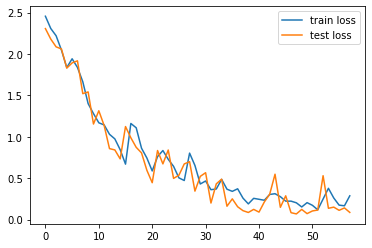

In [68]:
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='test loss')
# plt.legend()
# plt.show()

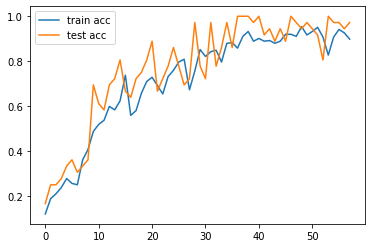

In [69]:
# plt.plot(history.history['categorical_accuracy'], label='train acc')
# plt.plot(history.history['val_categorical_accuracy'], label='test acc')
# plt.legend()
# plt.show()

In [70]:
# model.save("model13.h5")

In [8]:
model.load_weights('E:\8th sem\Major\Project\Sign_language_intepreter\model11.h5')

In [9]:
import pickle
pickle.dump(model, open("save_model.sav",'wb'))

INFO:tensorflow:Assets written to: ram://4683bfa5-8312-4a1d-b320-73fc6b9f696d/assets


In [25]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss,val_acc)

2/2 [==============================] - 2s 11ms/step - loss: 0.0694 - categorical_accuracy: 0.9444
0.06936167180538177 0.9444444179534912


In [9]:
colors = [(245,117,16), (117,245,16), (16,117,245),(245,16,117),(117,16,245),(16,245,117),(100,245,50),(100,50,245),(50,100,245),(50,245,100),(245,100,50),(245,50,100)]
def prob_viz(res, actions, input_frame):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,10+num*40), (int(prob*100), 40+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 35+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)        
    return output_frame

In [11]:
sequence  = []
sentence = []
predictions = []
threshold = 0.5
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():        
        ret, img = cap.read()        
        image, results = mediapipe_detection(img, holistic)        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]  
            predictions.append(np.argmax(res)) 
            if np.unique(predictions[-10:])[0]==np.argmax(res):        
                if res[np.argmax(res)] > threshold:                   
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            image = prob_viz(res, actions, image)
        
        cv2.imshow('Video', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 153ms/step
